## Cleaning and Aggregation of the MTA Bridge and Tunnel Data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

In [266]:
bt_csv = '../data/mta_bridge_and_tunnel/hourly_mta_bridge_and_tunnel.csv.zip'

### 1. Load MTA Bridge and Tunnel Data

In [267]:
# not a very big file ~40mb, loading into main memory using Pandas 
bt_df = pd.read_csv(bt_csv)

In [268]:
# give ETC and Cash/Toll a simpler name
bt_df = bt_df.rename(columns={'# Vehicles - ETC (E-ZPass)': 'ETC', '# Vehicles - Cash/VToll': 'Cash/Toll'})

In [269]:
# roughly check the dataset to see if there are any null values
bt_df.info()
# turns out no null values, good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586280 entries, 0 to 1586279
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Plaza ID   1586280 non-null  int64 
 1   Date       1586280 non-null  object
 2   Hour       1586280 non-null  int64 
 3   Direction  1586280 non-null  object
 4   ETC        1586280 non-null  int64 
 5   Cash/Toll  1586280 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 72.6+ MB


In [270]:
# get data from 2020, since the first confirmed covid case in U.S. was in early 2020
def filter_date_year(s):
    items = s.split('/')
    return items[-1] == '2020'

In [271]:
# filter data
bt_covid = bt_df[bt_df['Date'].apply(filter_date_year)]

In [272]:
# add a new column representing total vehicle passes (ETC + Cash/Toll)
bt_covid['ETC+Cash/Toll'] = bt_covid['ETC'] + bt_covid['Cash/Toll']

/home/yunxiaos/miniconda3/envs/bigdata2020/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [273]:
bt_covid.head()

,Plaza ID,Date,Hour,Direction,ETC,Cash/Toll,ETC+Cash/Toll
0,21,04/18/2020,0,I,517,130,647
1,21,04/18/2020,1,I,305,92,397
2,21,04/18/2020,2,I,219,76,295
3,21,04/18/2020,3,I,229,65,294
4,21,04/18/2020,4,I,368,56,424


### 2. Number of Vehicle Passes (ETC or Cash/Toll) Each Month

In [274]:
# filter month
def filter_date_month(s, month='01'):
    '''
    month: 01, 02, 03, 04
    '''
    items = s.split('/')
    return items[0] == month

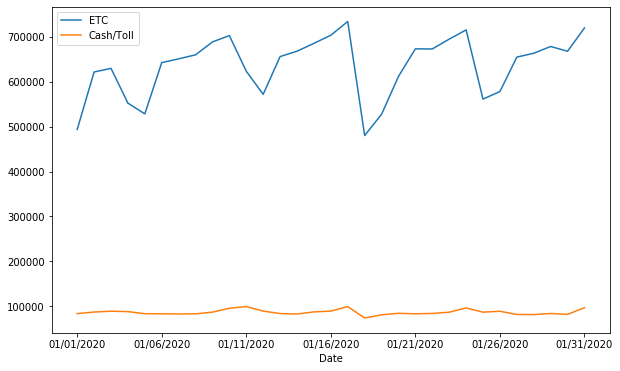

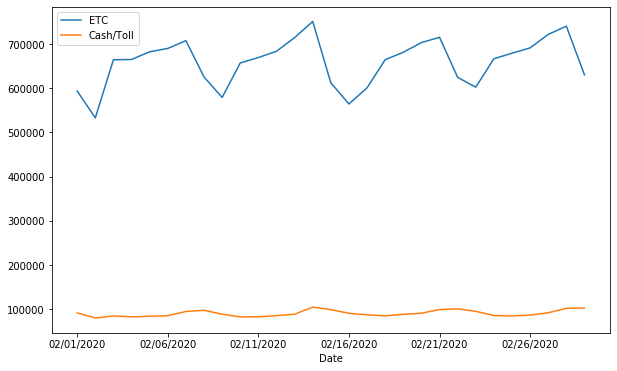

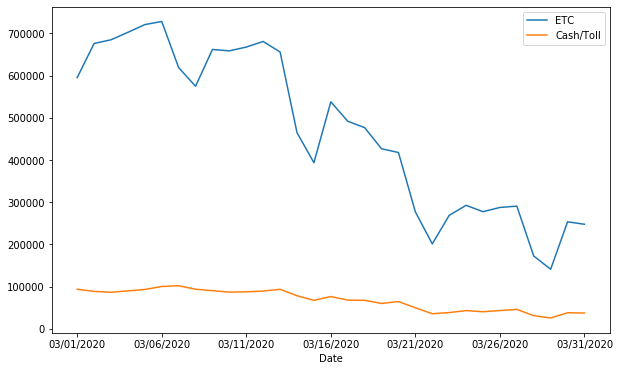

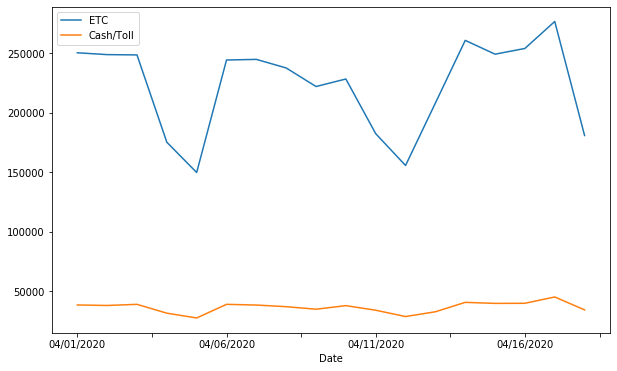

In [275]:
# plot ETC and Cash/Toll passes per month
months = ['01', '02', '03', '04']
month_dict = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr'}
for i, month in enumerate(months):
    p = lambda s: filter_date_month(s, month=month)
    ax = bt_covid[bt_covid['Date'].apply(p)][['Date', 'ETC', 'Cash/Toll']].groupby(['Date']).sum().plot()
    # ax.set_xlabel(month_dict[str(i + 1)])

### 3. Monthly Mean Total Vehicle Passes in Hours

We can see that the trend of total vehicle passes between different hours remains roughly the same each month, but the total amount per hour plummeted in Match and April due to covid-19.

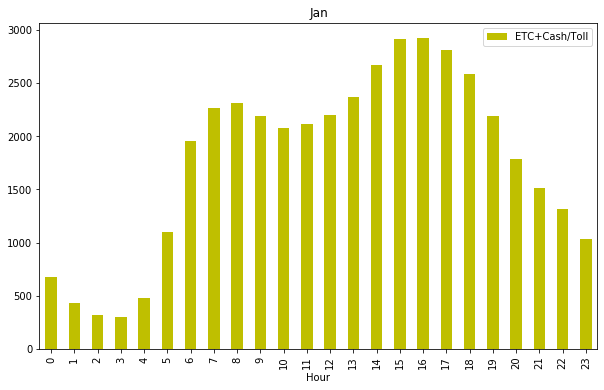

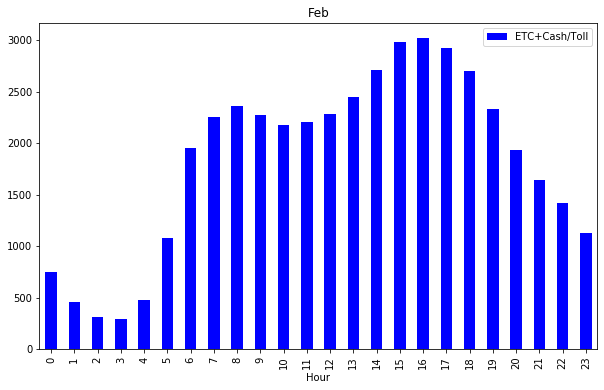

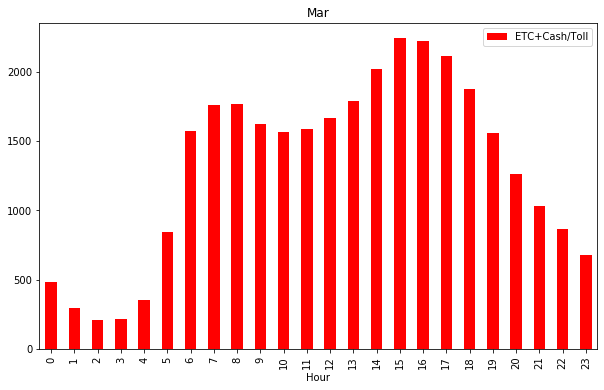

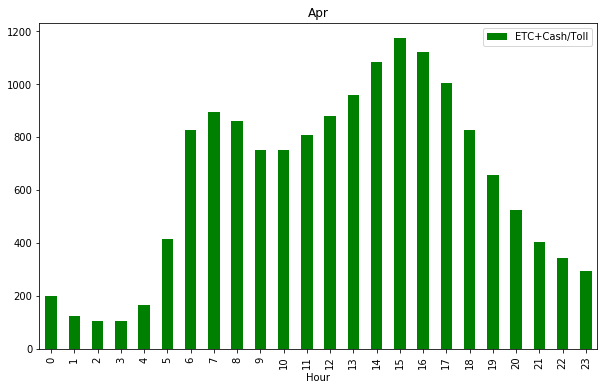

In [276]:
# calculate monthly average of total vehicle passes in each hour
month_dict = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr'}
colors = ['y', 'b', 'r', 'g']
for i, item in enumerate(month_dict.items()):
    p = lambda x: filter_date_month(x, month=item[0])
    bt_covid_month = bt_covid[bt_covid['Date'].apply(p)]
    bt_covid_month[['Date', 'Hour', 'ETC+Cash/Toll']].groupby(['Hour']).mean().plot(kind='bar', title=item[1], color=colors[i])

### 3. Percentage of Vehicles per Plaza

In [277]:
plaza_dict = {
    '21': 'Robert F. Kennedy Bridge Queens/ Bronx Plaza (TBX)', 
    '22': 'Robert F. Kennedy Bridge Manhattan Plaza (TBM)', 
    '23': 'Bronx-Whitestone Bridge (BWB)', 
    '24': 'Henry Hudson Bridge (HHB)', 
    '25': 'Marine Parkway-Gil Hodges Memorial Bridge (MPB)', 
    '26': 'Cross Bay Veterans Memorial Bridge (CBB)', 
    '27': 'Queens Midtown Tunnel (QMT)', 
    '28': 'Hugh L. Carey Tunnel (HCT)', 
    '29': 'Throgs Neck Bridge (TNB)', 
    '30': 'Verrazano-Narrows Bridge (VNB)'
}

In [278]:
p = lambda x: plaza_dict[str(x)]
bt_covid['Plaza ID'] = bt_covid['Plaza ID'].apply(p)

/home/yunxiaos/miniconda3/envs/bigdata2020/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


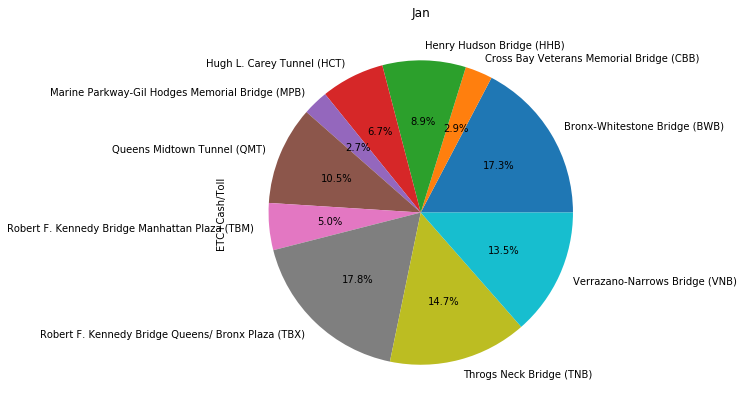

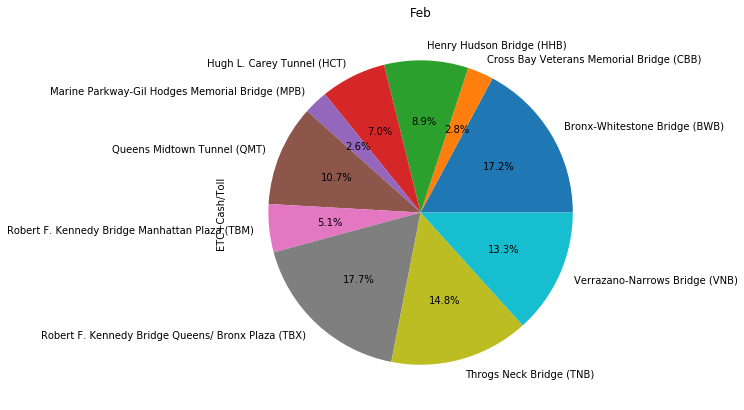

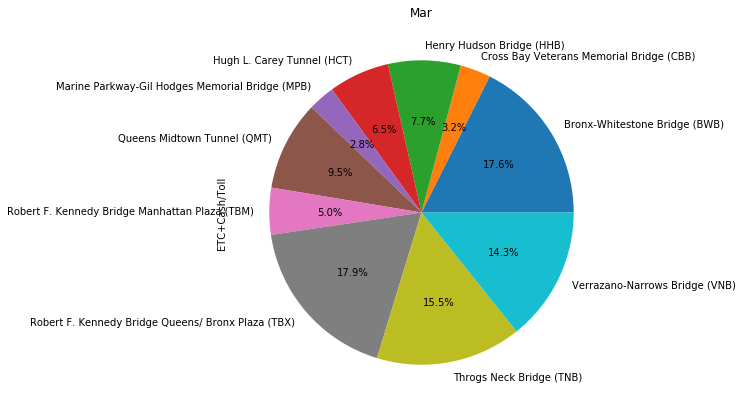

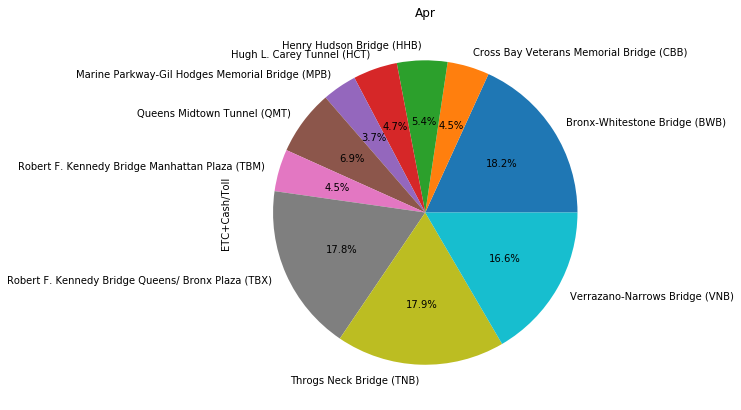

In [279]:
# calculate monthly average of total vehicle passes in each hour
month_dict = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr'}
colors = ['y', 'b', 'r', 'g']
for i, item in enumerate(month_dict.items()):
    p = lambda x: filter_date_month(x, month=item[0])
    bt_covid_month = bt_covid[bt_covid['Date'].apply(p)]
    bt_plaza = bt_covid_month[['Plaza ID', 'Date', 'ETC+Cash/Toll']].groupby(['Plaza ID']).sum()
    bt_plaza = bt_plaza.reset_index()
    bt_plaza.plot(kind='pie', y='ETC+Cash/Toll', labels=bt_plaza['Plaza ID'], figsize=(10, 7), 
                  autopct='%1.1f%%', legend=False, title=item[1])